In [ ]:
import sys
sys.path.append('..\\..\\..')

In [1]:
import os
sep_local = os.path.sep
sep_local

'/'

In [2]:
#done in case of linux
import os
os.chdir("/home/azeghost/git/Generative_Models")

In [5]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 950M, compute capability 5.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Compute dtype: float16
Variable dtype: float32


In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.2.0-dev20200118'

In [8]:
dataset_name = 'dsprites'

In [9]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='dsprites',
    version=0.1.0,
    description='dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth
independent latent factors. These factors are *color*, *shape*, *scale*,
*rotation*, *x* and *y* positions of a sprite.

All possible combinations of these latents are present exactly once,
generating N = 737280 total images.

### Latent factor values

*   Color: white
*   Shape: square, ellipse, heart
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: 40 values in [0, 2 pi]
*   Position X: 32 values in [0, 1]
*   Position Y: 32 values in [0, 1]

We varied one latent at a time (starting from Position Y, then Position X, etc),
and sequentially stored the images in fixed order.
Hence the order along the first dimension is fixed and allows you to map back to
the value of the latents corresponding to that image.

We chose the latents values deliberately to have the smallest step changes
while ensuring that all pixel outp

In [10]:
intermediate_dim = 20
inputs_shape=(64, 64, 1) # image shape
batch_size = 100
latent_dim = 50

In [11]:
TRAIN_BUF = 600
TEST_BUF = 100


In [12]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [13]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [14]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [15]:
#Not used here
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [16]:
model_name = dataset_name+'AE'

In [17]:
recoding_dir='..'+sep_local+'..'+sep_local+'recoding'+sep_local+model_name

In [18]:
import os

In [19]:
os.path.join(recoding_dir, model_name)

'../../recoding/dspritesAE/dspritesAE'

In [20]:
os.getcwd()

'/home/azeghost/git/Generative_Models'

In [21]:
from training.traditional.autoencoders.AE import AE

Using TensorFlow backend.
DEBUG:matplotlib:$HOME=/home/azeghost
DEBUG:matplotlib:CONFIGDIR=/home/azeghost/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/azeghost/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/azeghost/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 

DEBUG:matplotlib:CACHEDIR=/home/azeghost/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/azeghost/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [22]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_lays2
    }
    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays2
    }
]

In [23]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [24]:
_restore

'../../recoding/dspritesAE/var_save_dir'

In [25]:
ae = AE( 
    model_name=model_name, 
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    variables_params=variables_params, 
    restore=None
    )

  WARNING  | None
  WARNING  | None


Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                720050    
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                20

In [26]:
import numpy as np
n_generated = 36
random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

In [3]:
%load_ext autoreload
%autoreload 2
from data.gt_load.datasets import load
DATA_PATH = '/home/azeghost/datasets'
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [4]:
eval_dataset

  INFO     | ==================================================================
  DEBUG    | TRAIN
    Epoch: 0
    bce: -603605.75
    Total: -24.23484230041504
    Elapsed: 1256.778975
  INFO     | ==================================================================
  INFO     | ==================================================================
  DEBUG    | TEST
    Epoch: 0
    bce: -186670.796875
    Total: -20.72909164428711
    Elapsed: 232.195890
  INFO     | ==================================================================


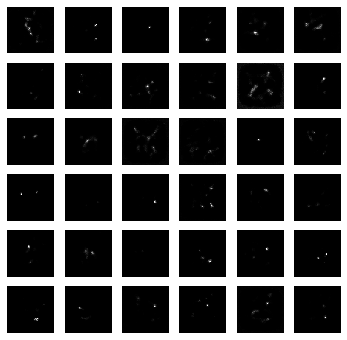

  CRITICAL | Saving Status in Epoch 0
Epochs Progress, Training Iterations 7372:   1%|          | 1/100 [1:07:12<110:53:07, 4032.20s/it]  INFO     | Training ... 


Epochs Progress, Training Iterations 5073:   1%|          | 1/100 [1:21:33<110:53:07, 4032.20s/it]

In [ ]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['image'],
    epochs=100,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5,
    gt_data = eval_dataset,
    gt_epoch = 1
)

In [ ]:
#The Cells below are old Ground truth Metrics measurements 
#now they are logged and saved with losses in the same manner during training 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from data.gt_load.datasets import load

In [ ]:
DATA_PATH = '..\\data\\gt_datasets'

In [ ]:
#DATA_PATH = 'C://Users//Khalid//Downloads//Generative Models//data//gt_datasets'

In [ ]:
eval_dataset = load(dataset_name='dsprites_full', dataset_path=DATA_PATH)

In [ ]:
import numpy as np

In [ ]:
def rep_func(x):
    z, mean, logvar = vae.encode(x)
    return z

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from evaluation.unsupervised_metrics.compute_metrics import compute_unsupervised_metrics

In [ ]:
us_scores = compute_unsupervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=737280,
    batch_size=batch_size
)
    

In [ ]:
us_scores

In [ ]:
from evaluation.supervised_metrics.compute_metrics import compute_supervised_metrics

In [ ]:
s_scores = compute_supervised_metrics(
    ground_truth_data=eval_dataset, 
    representation_function=rep_func, 
    random_state=np.random.RandomState(0),
    num_train=10000,
    num_test=2000,
    continuous_factors=False,
    batch_size=batch_size
)
    

In [ ]:
s_scores